# Experiment and path specification

In [1]:
# Specify the experiment for analysis
experiment='cxic00318'
runNumber = 200

# Set the installation and output path
import os
os.environ['INSTALLPATH']= '/cds/home/i/igabalsk/TRXS-Run18'
os.environ['OUTPUTPATH']= '/cds/data/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [2]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *

# Determine current user
currentUser, error = unixCMD("echo $USER")
currentUser = currentUser.strip()
print(currentUser)
os.environ['RESULTSPATH']= ('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

Current user is igabalsk will output batch to /cds/data/psdm/cxi/cxic00318/scratch/igabalsk/Batch
igabalsk


# Leveraging the batch queue to quickly grab point data

## Loading libraries

In [3]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsLibraries')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

IOError: Did you load the correct file? /cds/data/psdm/cxi/cxic00318/scratch/Memories/getCSPADcoords
Current user is igabalsk will output batch to /cds/data/psdm/cxi/cxic00318/scratch/igabalsk/Batch


## Grabbing point data across nodes

In [4]:

detDict = {'ebeamcharge':{'name':'EBeam', 'get-function': 'getEbeamCharge'},
           'xrayEnergy':{'name':'FEEGasDetEnergy','get-function': 'getXrayEnergy' },
          'seconds':{'name':'seconds', 'get-function': 'getSeconds'},
          'nanoseconds':{'name':'nanonseconds', 'get-function': 'getNanoseconds'},
          'fiducials':{'name':'fiducials', 'get-function': 'getFiducials'}}


batchThreads = batchPointDataGrabber( detDict, eventMax=1e5, experiment=experiment, runNumber=runNumber, rank=1 )
batchThreads.Queue = 'psanaq'
batchThreads.start()

Deleting the old output file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=1000]" -q psanaq -o /cds/data/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/pointData-run200-temp0.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Python/pointData-run200-temp0.py'
Output: Job <915580> is submitted to queue <psanaq>.

Error: 


## Check job status

In [7]:
stdoutdata, stderrdata = bjobs()
print stdoutdata
print stderrdata

JOBID   USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
915580  igabals RUN   psanaq     psanagpu111 psana1107   *-temp0.py Nov 10 17:08


/cds/data/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/nodePointDataGrabber0-run-200 remembered!


## Kill threads if they die

In [82]:
batchThreads.requestStop()
time.sleep(5)
bkill(killAll=True)

('', 'No unfinished job found\n')

In [48]:
batchThreads.status

'Finished'

In [49]:
batchThreads.gather()

/cds/data/psdm/cxi/cxic00318/scratch/igabalsk/Batch/Output/nodePointDataGrabber0-run-200 remembered!


## Drop empty array values

In [8]:
pointData = batchThreads.detArrays

def dropEmpty(pointData):

    filledBin = (pointData['seconds'] > 0)

    for key in pointData.keys():
        pointData[key]=pointData[key][filledBin] 
        
    return pointData

def dropNaN(pointData):
    
    goodBin = (~np.isnan(pointData['ebeamcharge']))
    
    for key in pointData.keys():
        pointData[key]=pointData[key][goodBin] 
        
    return pointData

pointData = dropEmpty(pointData)
pointData = dropNaN(pointData)


## Save point data

In [9]:
save_obj( pointData, os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )

## Plot histogram of result

/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


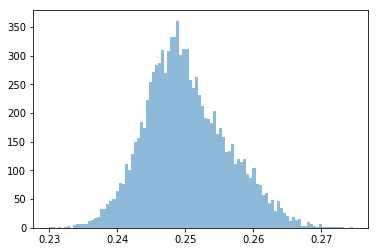

In [10]:
detArrays = pointData

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['ebeamcharge'], bins=100,normed=False, alpha=0.5);